# Introduction
 In this kernel, based on the features generated in **eda-and-feature-engineering.ipynb** we will create a baseline model. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from datetime import datetime
import calendar
from math import sin, cos, sqrt, atan2, radians,asin

from datetime import timedelta
import datetime as dt
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
plt.style.use('fivethirtyeight')
import folium
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import operator
import pickle
import os

In [2]:
train=pd.read_csv('train_cleaned.csv')
test=pd.read_csv('test_cleaned.csv')
print("Shape of Training Data ",train.shape)
print("Shape of Testing Data ",test.shape)

Shape of Training Data  (5871290, 29)
Shape of Testing Data  (9914, 28)


### Pre-Processing data

1. Remove the unwanted columns like pickup_datetime, key, pickup_date, latitude and longitude rounded to 3 decimal places
2. One hot encoding of categorical variables
3. Divide training data into train and validation datasets - 80% training and 20% validation

In [3]:
drop_columns=['key','pickup_datetime','pickup_date','pickup_latitude_round3','pickup_longitude_round3','dropoff_latitude_round3','dropoff_longitude_round3']

In [4]:
train_1=train.drop(drop_columns,axis=1)
test_1=test.drop(drop_columns,axis=1)
print("Shape of Training Data after dropping columns",train_1.shape)
print("Shape of Testing Data after dropping columns",test_1.shape)

Shape of Training Data after dropping columns (5871290, 22)
Shape of Testing Data after dropping columns (9914, 21)


In [5]:
train_1=pd.get_dummies(train_1)
test_1=pd.get_dummies(test_1)

print("Shape of Training Data after One Hot Encoding",train_1.shape)
print("Shape of Testing Data after One Hot Encoding",test_1.shape)

Shape of Training Data after One Hot Encoding (5871290, 32)
Shape of Testing Data after One Hot Encoding (9914, 31)


In [6]:
X=train_1.drop(['fare_amount'],axis=1)
y=train_1['fare_amount']

In [7]:
#split data into train and validation data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)
print("Number of records in training data ",X_train.shape[0])
print("Number of records in validation data ",X_test.shape[0])

Number of records in training data  4697032
Number of records in validation data  1174258


### Model Building
#### 1. Linear Regression

In [8]:
lm = LinearRegression()
lm.fit(X_train,y_train)
y_pred=lm.predict(X_test)
lm_rmse=np.sqrt(mean_squared_error(y_pred, y_test))
print("RMSE for Linear Regression is ",lm_rmse)

RMSE for Linear Regression is  4.78556142469167


In [9]:
linear_reg_pred=lm.predict(test_1)


In [10]:
submissions=pd.read_csv('sample_submission.csv')

In [11]:
submissions['fare_amount']=linear_reg_pred
submissions.to_csv("LinearRegression_Baseline.csv",index=False)

#### 2. XGBOOST

In [12]:
def XGBoost(X_train,X_test,y_train,y_test,num_rounds=300):
    dtrain = xgb.DMatrix(X_train,label=y_train)
    dtest = xgb.DMatrix(X_test,label=y_test)

    return xgb.train(params={'objective':'reg:linear','eval_metric':'rmse'}
                    ,dtrain=dtrain,num_boost_round=num_rounds, 
                    early_stopping_rounds=20,evals=[(dtest,'test')],)

In [13]:
xgbm = XGBoost(X_train,X_test,y_train,y_test)
xgbm_pred = xgbm.predict(xgb.DMatrix(test_1), ntree_limit = xgbm.best_ntree_limit)

[16:49:32] WARNING: /usr/local/miniconda/conda-bld/xgboost_1566327371504/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:32] WARNING: /usr/local/miniconda/conda-bld/xgboost_1566327371504/work/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	test-rmse:10.5935
Will train until test-rmse hasn't improved in 20 rounds.
[1]	test-rmse:8.01944
[2]	test-rmse:6.37542
[3]	test-rmse:5.37986
[4]	test-rmse:4.80239
[5]	test-rmse:4.47102
[6]	test-rmse:4.28959
[7]	test-rmse:4.17167
[8]	test-rmse:4.10529
[9]	test-rmse:4.05774
[10]	test-rmse:4.02843
[11]	test-rmse:4.00925
[12]	test-rmse:3.98432
[13]	test-rmse:3.97286
[14]	test-rmse:3.96216
[15]	test-rmse:3.94298
[16]	test-rmse:3.93469
[17]	test-rmse:3.92254
[18]	test-rmse:3.91745
[19]	test-rmse:3.91157
[20]	test-rmse:3.90022
[21]	test-rmse:3.89795
[22]	test-rm

In [14]:
submissions['fare_amount']=xgbm_pred
submissions.to_csv("XGboost_Baseline.csv",index=False)

Text(0.5, 1.0, 'Feature Importance')

<Figure size 432x288 with 0 Axes>

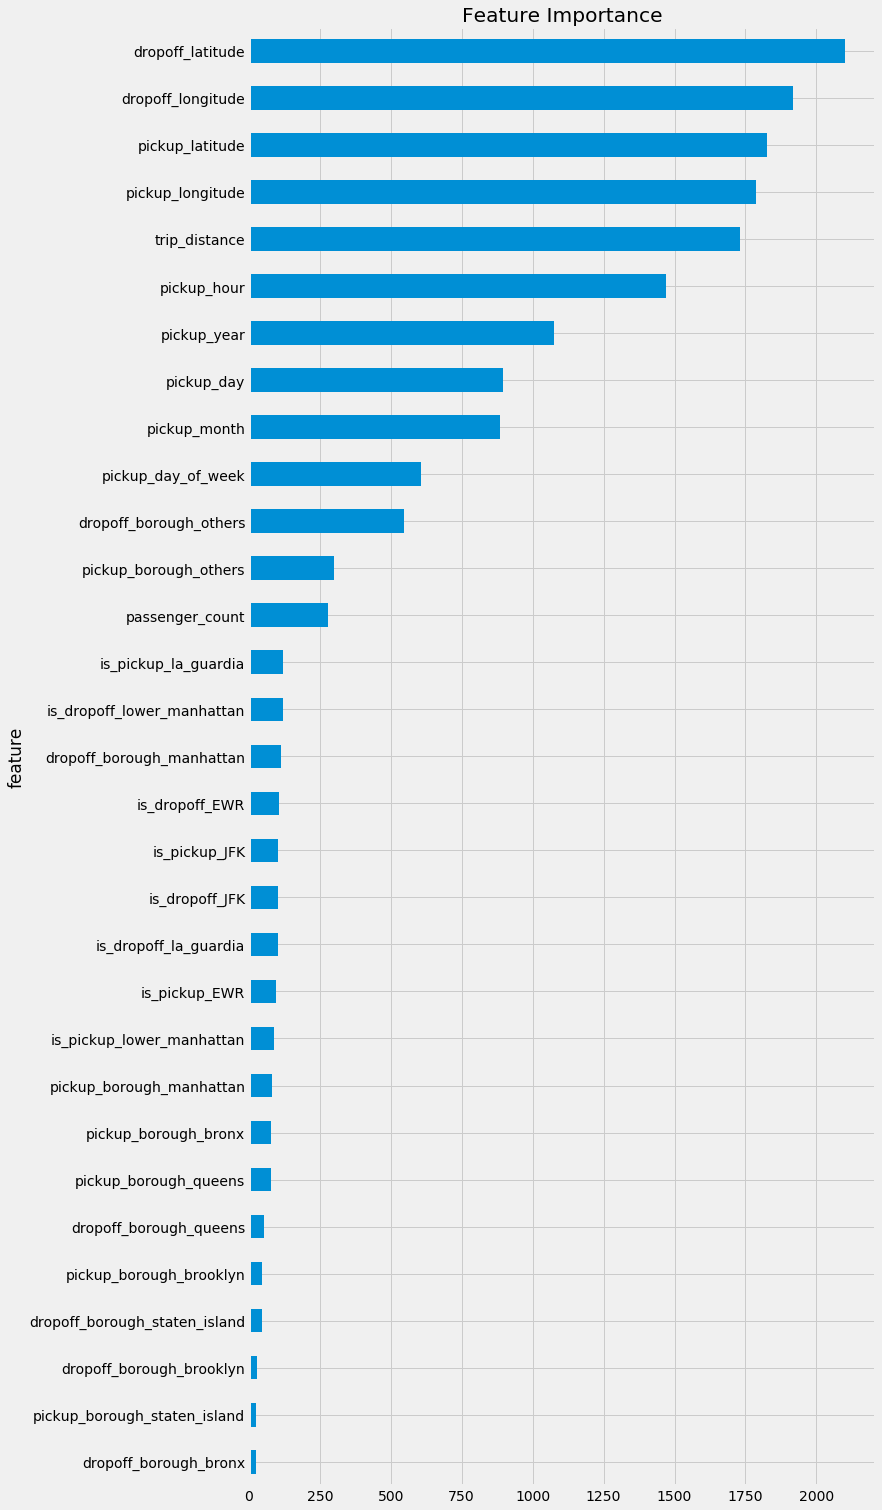

In [15]:
importance=xgbm.get_score()
importance = sorted(importance.items(), key=operator.itemgetter(1))
df = pd.DataFrame(importance, columns=['feature', 'score'])
plt.figure()

df.plot(kind='barh', x='feature', y='score', legend=False, figsize=(10, 25))
plt.title("Feature Importance")

The XGBoost scored 3.03760 on the leader board compared to rmse of 4.53265 for Linear Regression. From the importance graph above, we also observed that is_airport_pickup/dropoff features are not having more importance. But in the exploratory analysis we saw that There is a effect of airport on the price. 
To take into consideration the same, we can add features like distance from the three airports

Shape of Training Data after dropping columns (5871290, 28)
Shape of Testing Data after dropping columns (9914, 27)
Shape of Training Data after One Hot Encoding (5871290, 38)
Shape of Testing Data after One Hot Encoding (9914, 37)
Number of records in training data  4697032
Number of records in validation data  1174258
[18:22:15] WARNING: /usr/local/miniconda/conda-bld/xgboost_1566327371504/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:22:15] WARNING: /usr/local/miniconda/conda-bld/xgboost_1566327371504/work/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	test-rmse:10.5921
Will train until test-rmse hasn't improved in 20 rounds.
[1]	test-rmse:8.0305
[2]	test-rmse:6.38796
[3]	test-rmse:5.39553
[4]	test-rmse:4.81492
[5]	test-rmse:4.47682
[6]	test-rmse:4.29384
[7]	test-rmse:4.18206
[8]	test-rm

[314]	test-rmse:3.6665
[315]	test-rmse:3.66585
[316]	test-rmse:3.66583
[317]	test-rmse:3.66537
[318]	test-rmse:3.66505
[319]	test-rmse:3.66475
[320]	test-rmse:3.66464
[321]	test-rmse:3.66446
[322]	test-rmse:3.66397
[323]	test-rmse:3.66406
[324]	test-rmse:3.66396
[325]	test-rmse:3.66567
[326]	test-rmse:3.66549
[327]	test-rmse:3.6651
[328]	test-rmse:3.66512
[329]	test-rmse:3.66526
[330]	test-rmse:3.66513
[331]	test-rmse:3.66493
[332]	test-rmse:3.66482
[333]	test-rmse:3.66539
[334]	test-rmse:3.66536
[335]	test-rmse:3.66534
[336]	test-rmse:3.66507
[337]	test-rmse:3.66503
[338]	test-rmse:3.66526
[339]	test-rmse:3.66502
[340]	test-rmse:3.66506
[341]	test-rmse:3.66488
[342]	test-rmse:3.66478
[343]	test-rmse:3.66431
[344]	test-rmse:3.66424
Stopping. Best iteration:
[324]	test-rmse:3.66396



<Figure size 432x288 with 0 Axes>

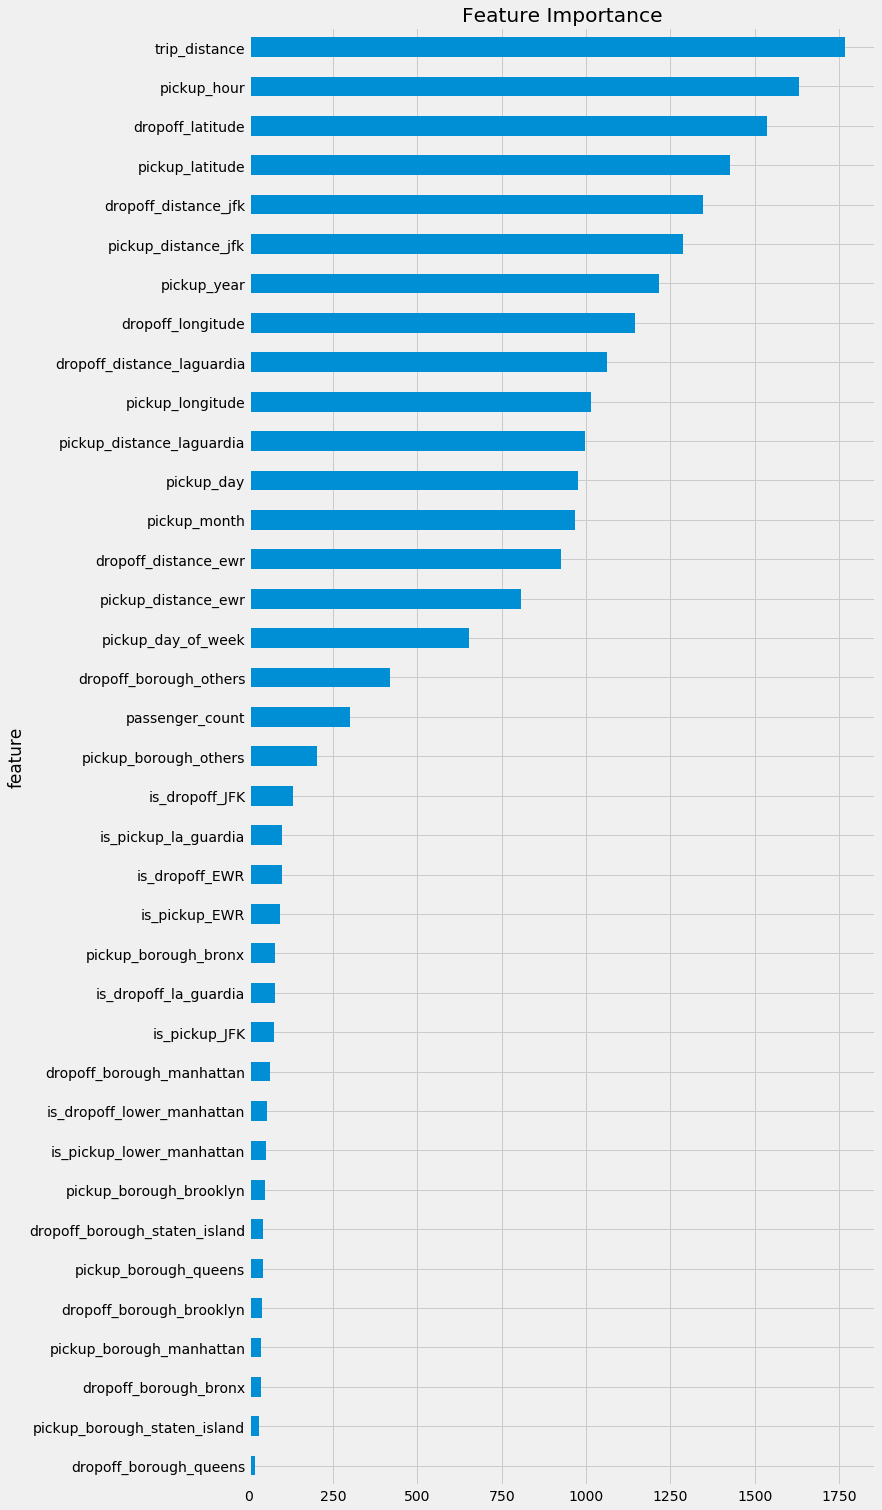

In [16]:
del train_1
del test_1
del X_train,X_test,y_train,y_test
lgr=(-73.8733, 40.7746)
jfk=(-73.7900, 40.6437)
ewr=(-74.1843, 40.6924)


def distance(lat1,lon1,lat2,lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a))

test['pickup_distance_jfk']=test.apply(lambda row:distance(row['pickup_latitude'],row['pickup_longitude'],jfk[1],jfk[0]),axis=1)
test['dropoff_distance_jfk']=test.apply(lambda row:distance(row['dropoff_latitude'],row['dropoff_longitude'],jfk[1],jfk[0]),axis=1)
test['pickup_distance_ewr']=test.apply(lambda row:distance(row['pickup_latitude'],row['pickup_longitude'],ewr[1],ewr[0]),axis=1)
test['dropoff_distance_ewr']=test.apply(lambda row:distance(row['dropoff_latitude'],row['dropoff_longitude'],ewr[1],ewr[0]),axis=1)
test['pickup_distance_laguardia']=test.apply(lambda row:distance(row['pickup_latitude'],row['pickup_longitude'],lgr[1],lgr[0]),axis=1)
test['dropoff_distance_laguardia']=test.apply(lambda row:distance(row['dropoff_latitude'],row['dropoff_longitude'],lgr[1],lgr[0]),axis=1)



train['pickup_distance_jfk']=train.apply(lambda row:distance(row['pickup_latitude'],row['pickup_longitude'],jfk[1],jfk[0]),axis=1)
train['dropoff_distance_jfk']=train.apply(lambda row:distance(row['dropoff_latitude'],row['dropoff_longitude'],jfk[1],jfk[0]),axis=1)
train['pickup_distance_ewr']=train.apply(lambda row:distance(row['pickup_latitude'],row['pickup_longitude'],ewr[1],ewr[0]),axis=1)
train['dropoff_distance_ewr']=train.apply(lambda row:distance(row['dropoff_latitude'],row['dropoff_longitude'],ewr[1],ewr[0]),axis=1)
train['pickup_distance_laguardia']=train.apply(lambda row:distance(row['pickup_latitude'],row['pickup_longitude'],lgr[1],lgr[0]),axis=1)
train['dropoff_distance_laguardia']=train.apply(lambda row:distance(row['dropoff_latitude'],row['dropoff_longitude'],lgr[1],lgr[0]),axis=1)


train_1=train.drop(drop_columns,axis=1)
test_1=test.drop(drop_columns,axis=1)
print("Shape of Training Data after dropping columns",train_1.shape)
print("Shape of Testing Data after dropping columns",test_1.shape)


train_1=pd.get_dummies(train_1)
test_1=pd.get_dummies(test_1)

print("Shape of Training Data after One Hot Encoding",train_1.shape)
print("Shape of Testing Data after One Hot Encoding",test_1.shape)

X=train_1.drop(['fare_amount'],axis=1)
y=train_1['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)
print("Number of records in training data ",X_train.shape[0])
print("Number of records in validation data ",X_test.shape[0])

xgbm = XGBoost(X_train,X_test,y_train,y_test,num_rounds=1500)
xgbm_pred = xgbm.predict(xgb.DMatrix(test_1), ntree_limit = xgbm.best_ntree_limit)

submissions['fare_amount']=xgbm_pred
submissions.to_csv("XGboost_WithDistancetoAirport.csv",index=False)

importance=xgbm.get_score()
importance = sorted(importance.items(), key=operator.itemgetter(1))
df = pd.DataFrame(importance, columns=['feature', 'score'])
plt.figure()

df.plot(kind='barh', x='feature', y='score', legend=False, figsize=(10, 25))
plt.title("Feature Importance")

train.to_csv("train_cleaned.csv",index=False)
test.to_csv("test_cleaned.csv",index=False)